In [ ]:
import numpy as np

from math import pi

from qiskit.circuit import QuantumCircuit, Parameter

from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp

from qiskit.primitives import StatevectorEstimator, StatevectorSampler

from qiskit_aer.primitives import SamplerV2 as AerSampler
from qiskit_aer import AerSimulator

from scipy.optimize import minimize



$ H(x) = - \sum_i v_i x_i + A(\sum_i w_i x_i - C)^2 $

$A$ is a penalty constant $>$ max($w_i$)

Map binary $x_i = (1 - Z_i) / 2$ into Pauli-Z operators

In [5]:
def create_knapsack_hamiltonian(weights, vals, cap, penalty):
    n = len(vals)

    Q = np.zeros((n, n))
    lin = np.zeros(n)

    # obj: -v_i x_i
    lin -= np.array(vals)
    
    for i in range(n):
        lin[i] += penalty * (weights[i] ** 2 - 2 * cap * weights[i])
        for j in range(i + 1, n):
            Q[i, j] += 2 * penalty * weights[i] * weights[j]

    # const = penalty * cap ** 2

    # map to hamiltonian / ising
    paulis = []
    coeffs = []

    for i in range(n):
        # linear term
        if abs(lin[i]) > 1e-9:
            coeffs.append(lin[i] / 2)
            paulis.append("I" * (n - i - 1) + "Z" + "I" * i)

    for i in range(n):
        for j in range(i + 1, n):
            if abs(Q[i, j]) > 1e-9:
                coeffs.append(Q[i, j] / 4)
                label = ["I"] * n
                label[n - i - 1] = "Z"
                label[n - j - 1] = "Z"
                paulis.append("".join(label))
    
    hamiltonian = SparsePauliOp.from_list(list(zip(paulis, coeffs)))
    return hamiltonian
    

In [6]:
vals = [5, 4, 6]
weights = [2, 3, 4]
cap = 5
pen = 10 # > max(weights)

# problem hamiltonian
hamiltonian = create_knapsack_hamiltonian(weights, vals, cap, pen)

print(hamiltonian)

SparsePauliOp(['IIZ', 'IZI', 'ZII', 'IZZ', 'ZIZ', 'ZZI'],
              coeffs=[ -82.5+0.j, -107. +0.j, -123. +0.j,   30. +0.j,   40. +0.j,   60. +0.j])


In [16]:
def cost_func(params, ansatz, hamiltonian, estimator):
    pub = (ansatz, hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs

    return cost

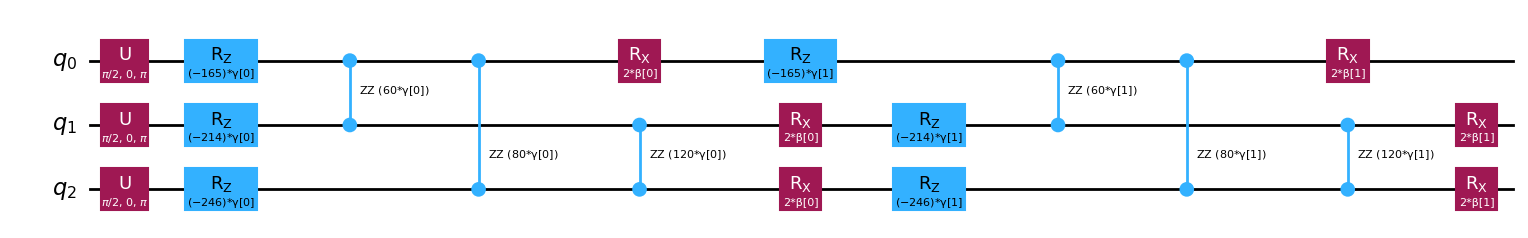

In [14]:
ansatz = QAOAAnsatz(hamiltonian, reps=2)
ansatz.decompose(reps=2).draw("mpl")

In [17]:
estimator = StatevectorEstimator()

x0 = 2 * np.pi * np.random.rand(ansatz.num_parameters)

cost = cost_func(x0, ansatz, hamiltonian, estimator)
print(cost)

-153.60175046169095


In [20]:
res = minimize(cost_func, x0, 
               args=(ansatz, hamiltonian, estimator),
               method="COBYLA")
print("Optimal params:", res.x)
print("Estimated ground state energy:", res.fun)

Optimal params: [0.96741493 2.50852624 4.47541849 3.69050438]
Estimated ground state energy: -163.24496357261444


In [ ]:
sampler = AerSampler()
job = sampler.run([(ansatz, res.x)], shots=1024)
dist = job.result()[0].data.values

print(dist)

# for bitstring, prob in dist.items():
#     x = [int(b) for b in bitstring[::-1]]
#     val = sum(v for v, b in zip(vals, x) if b)
#     weight = sum(w for w, b in zip(weights, x) if b)
#     print(x, "val:", val, "weight:", weight, "prob:", prob)



<bound method DataBin.values of DataBin()>


c:\Users\perso\Documents\USC\q3_hackathon\.q3hack\Lib\site-packages\qiskit\primitives\statevector_sampler.py:163: UserWarning: One of your circuits has no output classical registers and so the result will be empty. Did you mean to add measurement instructions?
  warnings.warn(
